#### Učitavanje potrebnih biblioteka

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import cross_validate

#### Učitaj skupove podataka i napravi početno uređivanje

In [7]:
# Učitaj skupove podataka
pumpkins_data=pd.read_excel('Datasets/PumpkinSeed.xlsx')

url_breast_cancer = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
column_names_bc = ["ID", "Diagnosis"] + ["Feature_" + str(i) for i in range(1, 31)]
breast_cancer_data = pd.read_csv(url_breast_cancer, header=None, names=column_names_bc)

url_wine = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
column_names_wine = ["Class"] + ["Feature_" + str(i) for i in range(1, 14)]
wine_data = pd.read_csv(url_wine, header=None, names=column_names_wine)

url_parkinsons = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
parkinsons_data = pd.read_csv(url_parkinsons)

url_liver = "https://archive.ics.uci.edu/ml/machine-learning-databases/00225/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv"
column_names_liver = ["Age", "Gender", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/G Ratio", "Selector"]
liver_data = pd.read_csv(url_liver, header=None, names=column_names_liver)

url_sonar = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
column_names_sonar = ["Feature_" + str(i) for i in range(1, 61)] + ["Class"]
sonar_data = pd.read_csv(url_sonar, header=None, names=column_names_sonar)

# Definiraj imena ciljnih varijabli
target_variable_names = {
    "pumpkins_data": "Class",
    "breast_cancer_data": "Diagnosis",
    "wine_data": "Class",
    "parkinsons_data": "status",
    "liver_data": "Selector",
    "sonar_data": "Class"
}

# Početno uredi skupove podataka
pumpkins_data['Class']=pumpkins_data['Class'].replace({'Çerçevelik':0,'Ürgüp Sivrisi':1})
breast_cancer_data['Diagnosis']=breast_cancer_data['Diagnosis'].replace({'B':0,'M':1})
parkinsons_data.drop(['name'],axis=1,inplace=True)
liver_data['Gender']=liver_data['Gender'].replace({'Male':0,'Female':1})
liver_data.dropna(subset=['A/G Ratio'], inplace=True)
sonar_data['Class']=sonar_data['Class'].replace({'R':0,'M':1})

datasets_list = [pumpkins_data, breast_cancer_data, wine_data, parkinsons_data, liver_data, sonar_data]
for dataset in datasets_list:
    dataset.drop_duplicates(inplace=True)

# Obradi skupove podataka i pripremi ih za treniranje
preprocessed_datasets = []
i = 0
for df in datasets_list:
    y = df[list(target_variable_names.values())[i]].values
    X = df.drop(columns=[list(target_variable_names.values())[i]])
    preprocessed_datasets.append((X, y))
    i = i +1

#### Definiranje metode za izračunavanje performansi algortiama nad skupom podataka

In [8]:
# Metoda za izracunavanje performansi algoritama za skup podataka
def izracunaj_performanse_norm_loc(X_train, y_train, algoritmi):
    results = []
    # Izracunaj preciznost i vrijeme izvršavanja za svaki algoritam
    scaler = StandardScaler()

    for name, clf in algoritmi.items():
        pipeline_normalized = Pipeline([
            ('scaler', scaler),
            ('model', clf)
        ])

        scores = cross_validate(pipeline_normalized, X_train, y_train, scoring=['accuracy'], cv=10, return_train_score=True, n_jobs=1)
        
        mean_test_accuracy = np.mean(scores['test_accuracy'])
        test_time = np.mean(scores['score_time'])

        # Unakrsna validacija može vratiti NaN vrijednosti, pogledati GitHub issue #27180
        if np.isnan(mean_test_accuracy):
            mean_test_accuracy = 0.000001
        if np.isnan(test_time):
            test_time = 1000000

        if mean_test_accuracy <= 0:
            mean_test_accuracy = 0.0000001
        if test_time <= 0:
            test_time = 0.0000001

        results.append({
            'Algoritam': name,
            'PreciznostAlgoritma': mean_test_accuracy,
            'VrijemeIzvrsavanja': test_time
        })

    df_results = pd.DataFrame(results)
    
    return df_results

#### Definiranje metode za izračunavanje Adjusted ratio of ratios mjere za algoritme nad skupovima podataka

In [9]:
# Metoda za izracunavanje ARR vrijednosti za skup podataka
def izracunaj_ARR_loc(df_results, alpha=0.05):
    arr_values = []
    for i, row_i in df_results.iterrows():
        arr_sum = 0
        for j, row_j in df_results.iterrows():
            if i != j:
                arr = (row_i['PreciznostAlgoritma'] / row_j['PreciznostAlgoritma']) / (1 + alpha * np.log(row_i['VrijemeIzvrsavanja'] / row_j['VrijemeIzvrsavanja']))
                arr_sum += arr
        arr_values.append(arr_sum / (len(df_results) - 1))

    result = dict(zip(df_results['Algoritam'], arr_values))

    return result

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from MtLModelAnalysis import *

algoritmi = algoritmi = {
            'LR': LogisticRegression(solver='lbfgs', max_iter=10000),
            'LDA': LinearDiscriminantAnalysis(),
            'CART': DecisionTreeClassifier(),
            "NB": GaussianNB(),
            "SVM": SVC(probability=True),
            "KNN": KNeighborsClassifier()
        }

alg_performances = []

for X, y in preprocessed_datasets:
    perforanseAlg = izracunaj_performanse_norm_loc(X, y, algoritmi)
    alg_performances.append(perforanseAlg)

alg_arr_values = []
alg_arr_values2 = [] # Za informativni graf prikazujemo ARR sa alfa = 0 i alfa = 0.2
alg_arr_values3 = []

for dataset_alg_performance in alg_performances:
    alg_arr_value = izracunaj_ARR_loc(dataset_alg_performance)
    alg_arr_values.append(alg_arr_value)

    alg_arr_values2.append(izracunaj_ARR_loc(dataset_alg_performance , 0))
    alg_arr_values3.append(izracunaj_ARR_loc(dataset_alg_performance, 0.2))

#### Grafički prikaz performansi algoritama nad skupovima podataka za bazu znanja

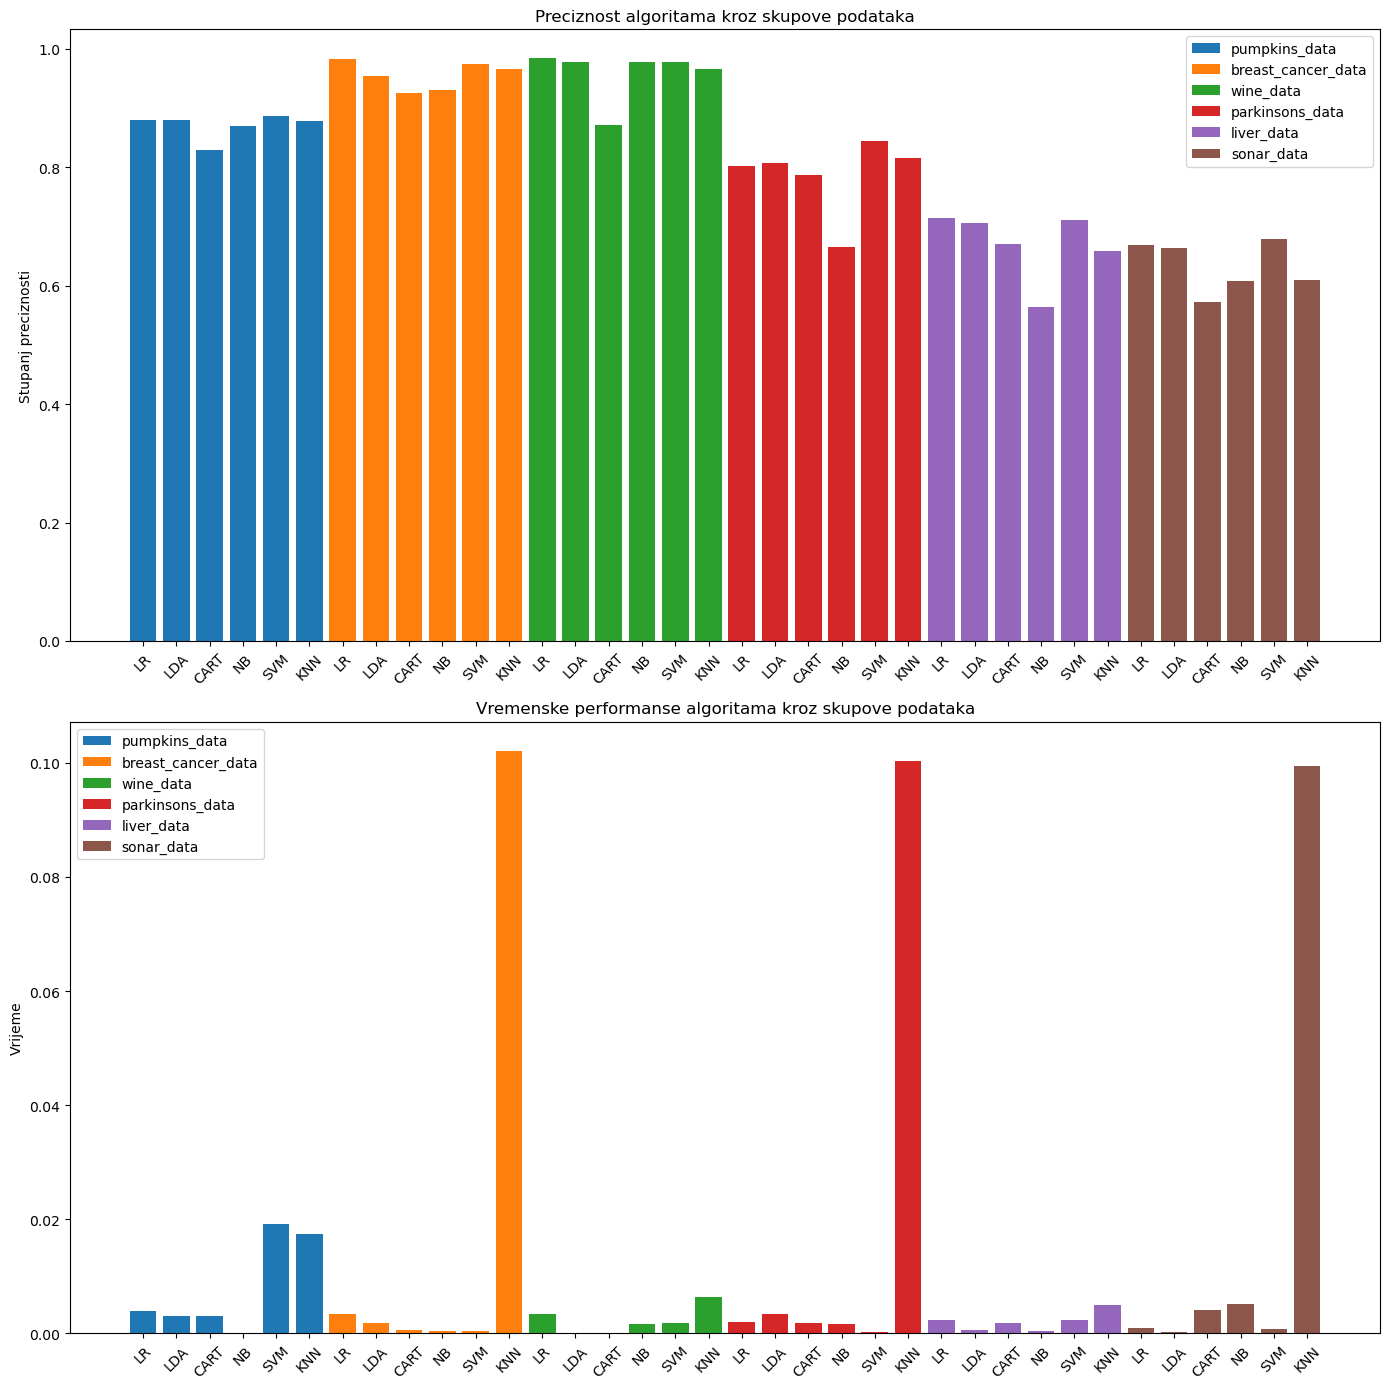

In [11]:
import matplotlib.pyplot as plt

dataset_names = list(target_variable_names.keys())

num_datasets = len(alg_performances)
algorithms = alg_performances[0]['Algoritam'].values

fig, ax = plt.subplots(2, 1, figsize=(14, 14))

bar_width = 0.1
spacing = 0.15

for index, (data, dataset_name) in enumerate(zip(alg_performances, dataset_names)):
    ax[0].bar(algorithms + "_" + str(index + 1), data['PreciznostAlgoritma'], label=dataset_name)
    ax[1].bar(algorithms + "_" + str(index + 1), data['VrijemeIzvrsavanja'], label=dataset_name)

ax[0].set_title('Preciznost algoritama kroz skupove podataka')
ax[0].set_ylabel('Stupanj preciznosti')
ax[0].set_xticks([(algo + "_" + str(i+1)) for i in range(num_datasets) for algo in algorithms])
ax[0].set_xticklabels([algo for i in range(num_datasets) for algo in algorithms], rotation=45)
ax[0].legend()

ax[1].set_title('Vremenske performanse algoritama kroz skupove podataka')
ax[1].set_ylabel('Vrijeme')
ax[1].set_xticks([(algo + "_" + str(i+1)) for i in range(num_datasets) for algo in algorithms])
ax[1].set_xticklabels([algo for i in range(num_datasets) for algo in algorithms], rotation=45)
ax[1].legend()

plt.tight_layout()
plt.show()

 #### Grafički prikaz vrijednosti ARR(Adjusted ratio of ratios) mjera algoritama za skupove podataka za bazu znanja

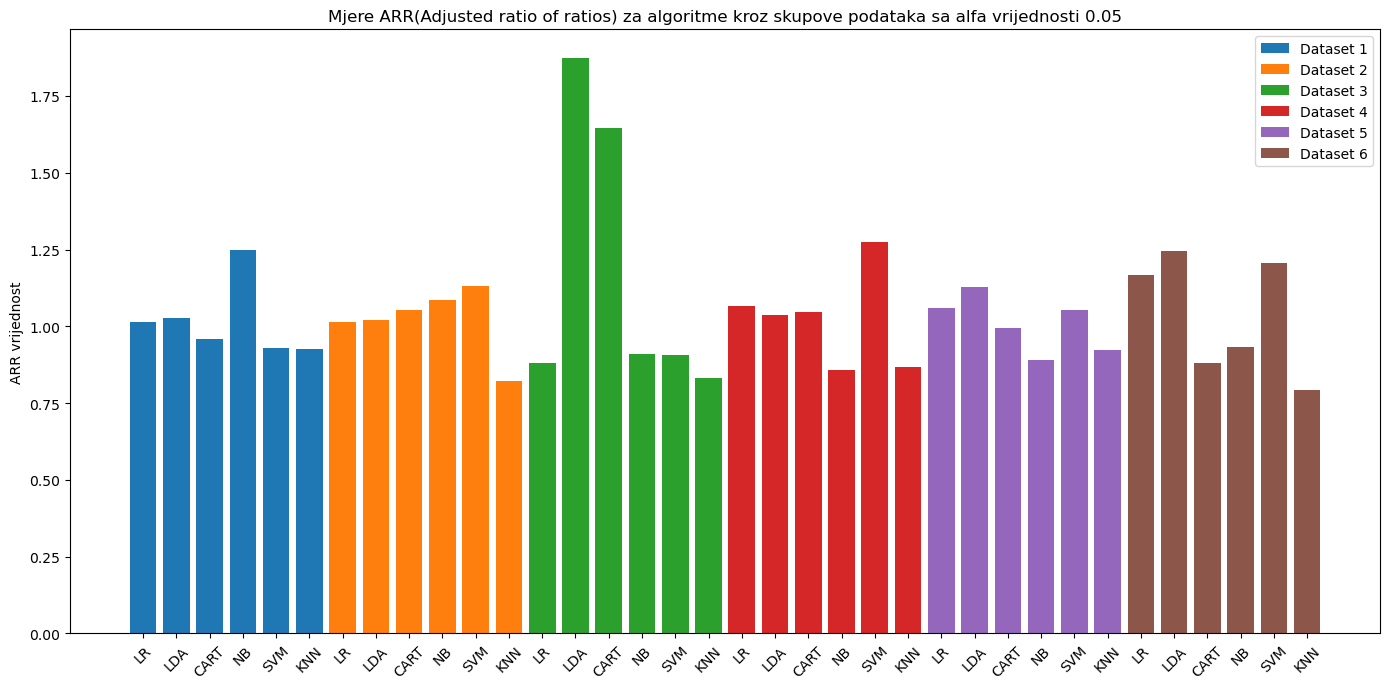

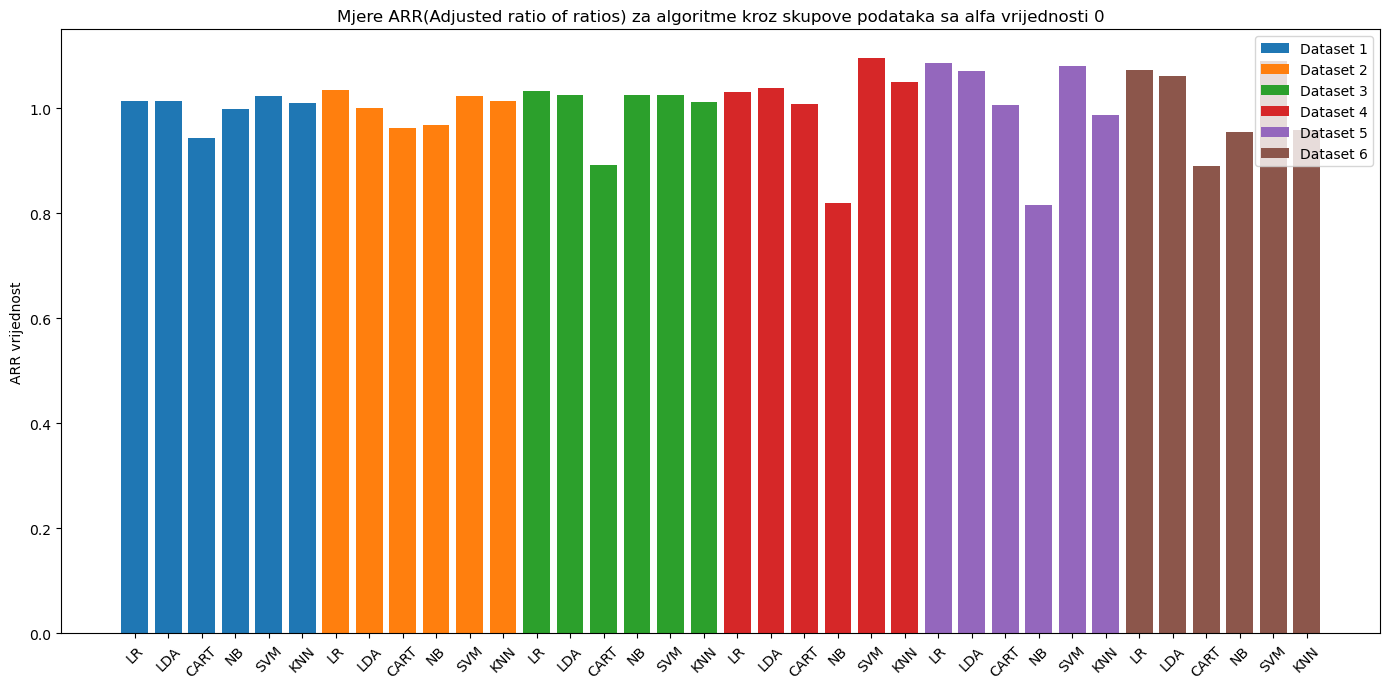

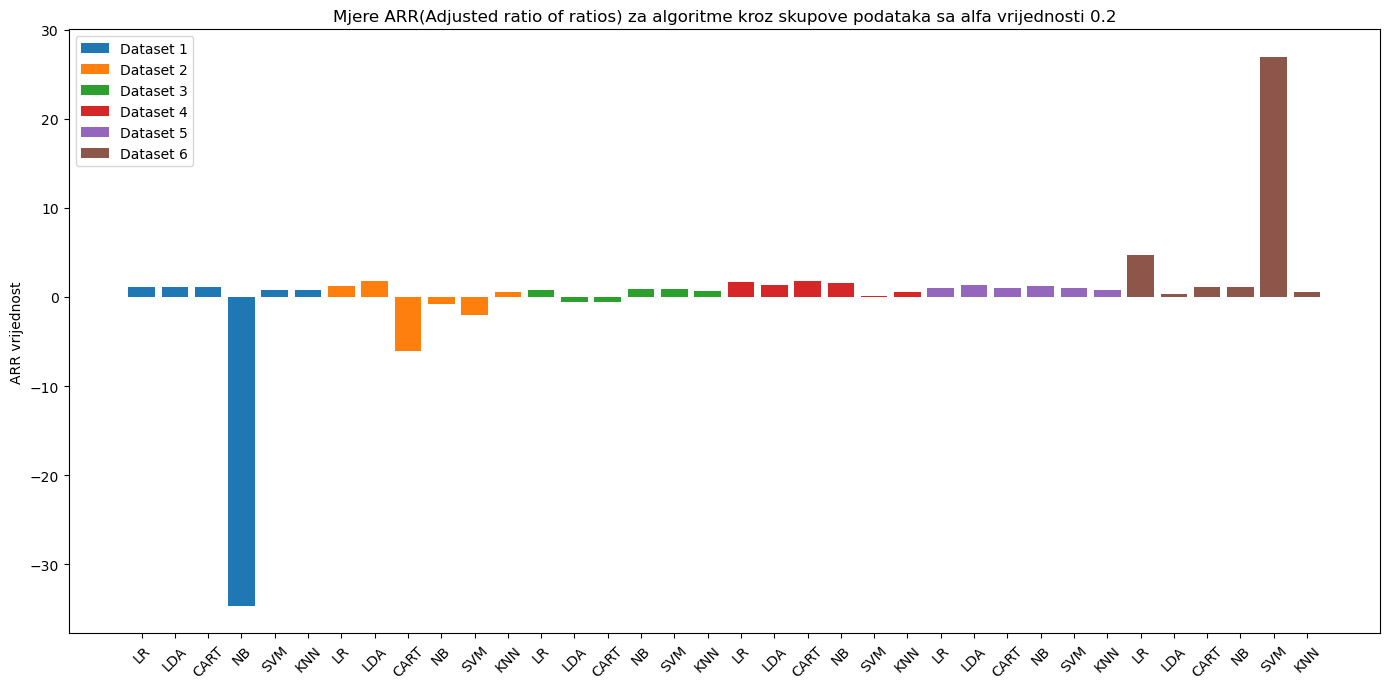

In [12]:
def plot_arr_values(arr_values_list, alfa_vrijednost):

    num_datasets = len(arr_values_list)
    algorithms = list(arr_values_list[0].keys())

    fig, ax = plt.subplots(figsize=(14, 7))

    for index, data in enumerate(arr_values_list):
        values = [data[algo] for algo in algorithms]
        ax.bar([algo + "_" + str(index + 1) for algo in algorithms], values, label='Dataset ' + str(index + 1))

    ax.set_title('Mjere ARR(Adjusted ratio of ratios) za algoritme kroz skupove podataka sa alfa vrijednosti ' + alfa_vrijednost)
    ax.set_ylabel('ARR vrijednost')
    
    ax.set_xticks([(algo + "_" + str(i+1)) for i in range(num_datasets) for algo in algorithms])
    ax.set_xticklabels([algo for i in range(num_datasets) for algo in algorithms], rotation=45)
    
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_arr_values(alg_arr_values, "0.05")
plot_arr_values(alg_arr_values2, "0")
plot_arr_values(alg_arr_values3, "0.2")

## Računanje i prikazivanje vrijednosti meta-značajki

#### Izračunavanje meta-značajki skupova podataka meta-modela

In [13]:
# Metoda za izracunavanje meta-znacajki u skupe podataka
def compute_metafeatures_loc(X, y, _mfe = None):
    if(_mfe == None):
        mfe = MFE(groups="all", features=["attr_ent", "joint_ent"], summary=["median", "min", "max"])
    else:
        mfe = _mfe
    
    if not isinstance(X, np.ndarray):
        X.to_numpy()
    if not isinstance(y, np.ndarray):
        y.to_numpy()
    
    mfe.fit(X, y)
    features, values = mfe.extract()
    
    metafeatures = dict(zip(features, values))
    return metafeatures

In [14]:
import copy
best_algorithms = []

# Postavi najbolji algoritam za svaki skup podataka
for arr_values in alg_arr_values:
    best_algorithm = max(arr_values, key=arr_values.get)
    best_value = arr_values[best_algorithm]
    best_algorithms.append({best_algorithm: best_value})

mfe_categories = ["general", "statistical", "info-theory", "model-based", "landmarking"]

meta_knowledge_mfe = []

for (X, y), best_algo in zip(preprocessed_datasets, best_algorithms):
    dataset_metafeatures = []
    
    for category in mfe_categories:
        mfe = MFE(groups=category, summary=["median"])
        metafeatures = compute_metafeatures_loc(X.to_numpy(), y, mfe)
        for key, value in metafeatures.items():
            if np.isnan(value):
                metafeatures[key] = 0
        dataset_metafeatures.append(metafeatures)
    
    dataset_metafeatures.append({"bestAlg": list(best_algo.keys())[0]})
    meta_knowledge_mfe.append(dataset_metafeatures)

c:\Users\Rajan\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Rajan\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Rajan\Anaconda3\Lib\site-packages\pymfe\statistical.py:1267: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(S_i)) for S_i in sample_cov_matrices
c:\Users\Rajan\Anaconda3\Lib\site-packages\pymfe\statistical.py:1272: RuntimeWarning: invalid value encountered in log
  * np.log(np.linalg.det(pooled_cov_mat))
c:\Users\Rajan\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was ren

In [15]:
# Pripremi vrijednosti meta-znacajki za model
def replace_dicts_with_values_exclude_last(data):
    replaced_data = []
    for sublist in data:
        replaced_sublist = [list(d.values()) if isinstance(d, dict) else d for d in sublist[:-1]]
        replaced_data.append(replaced_sublist)
    return replaced_data

meta_feature_model_dataset = replace_dicts_with_values_exclude_last(meta_knowledge_mfe)

#### Grafički prikaz meta-značajki svih skupova podataka meta-modela

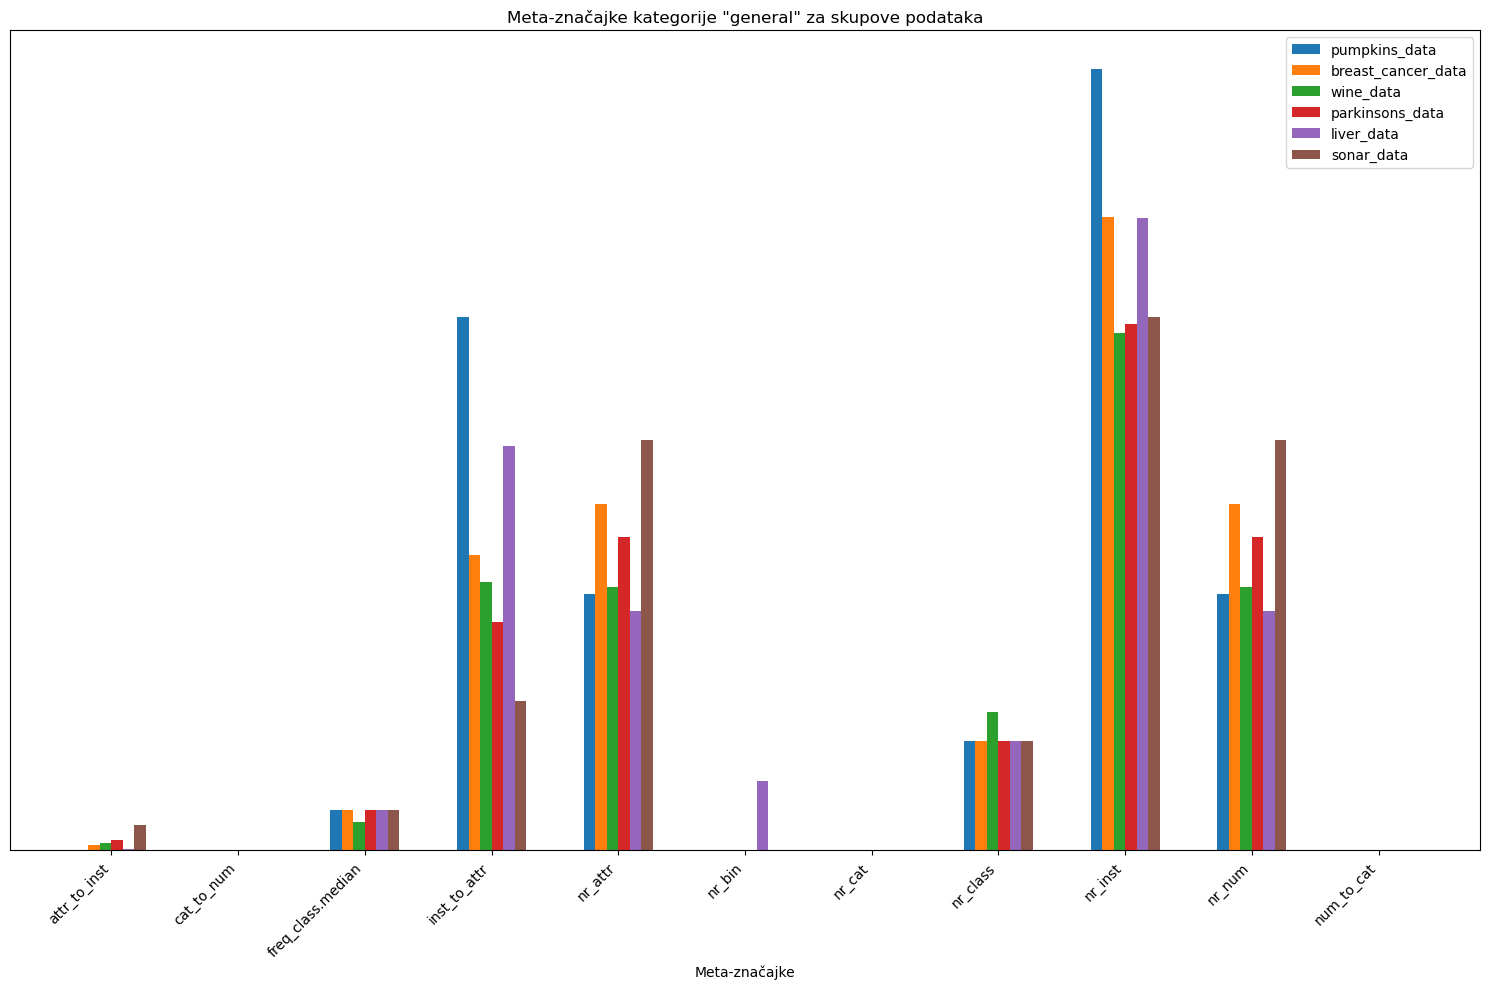

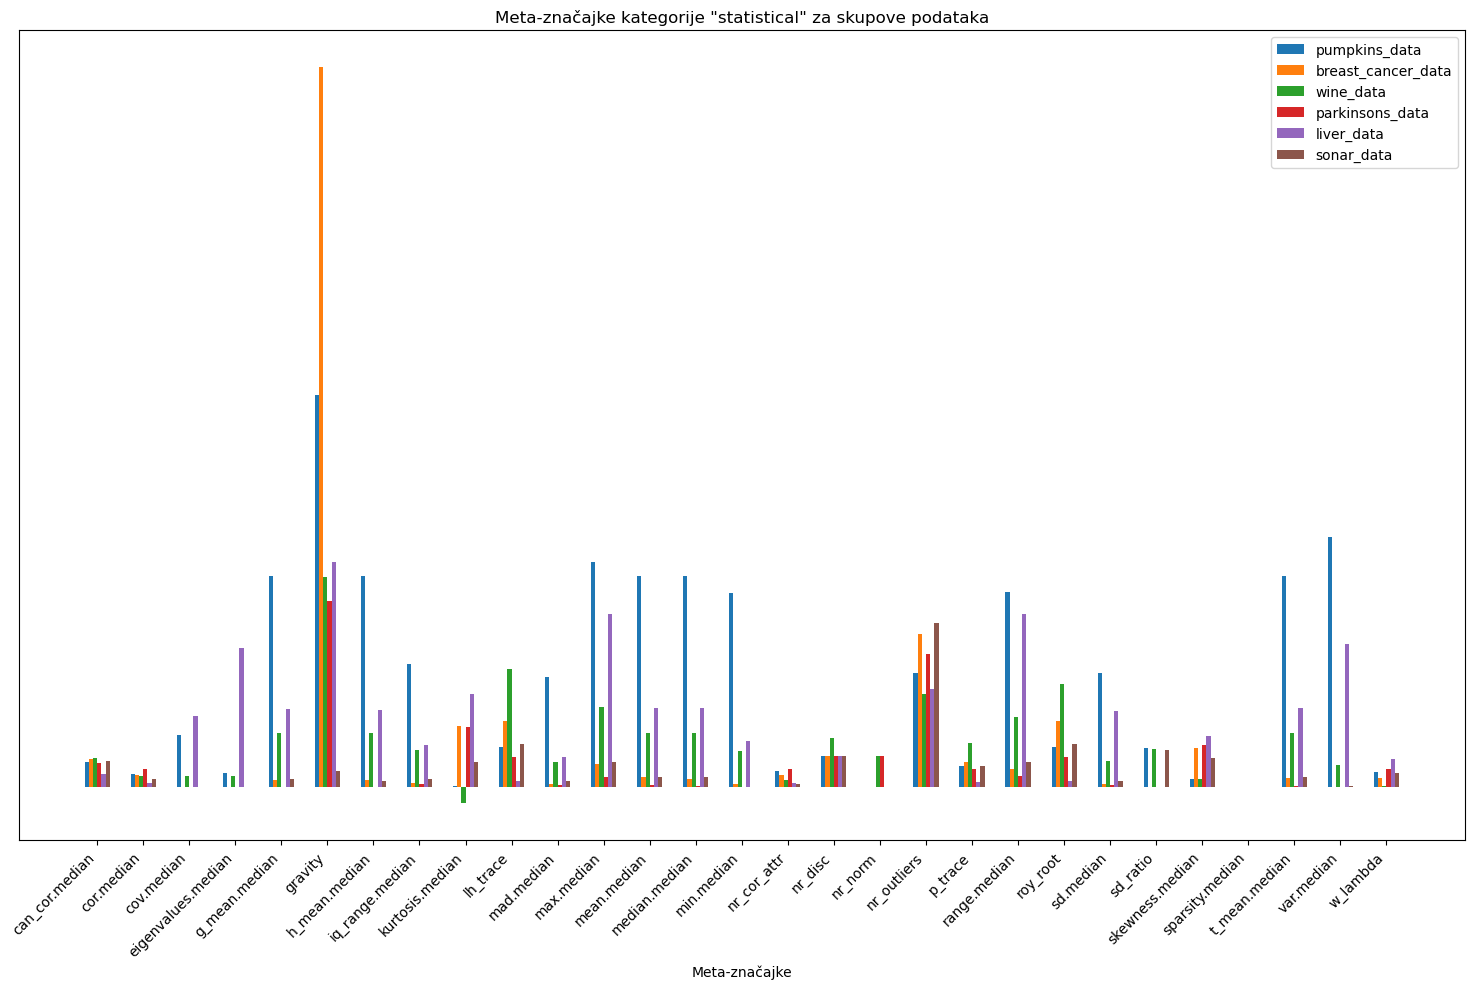

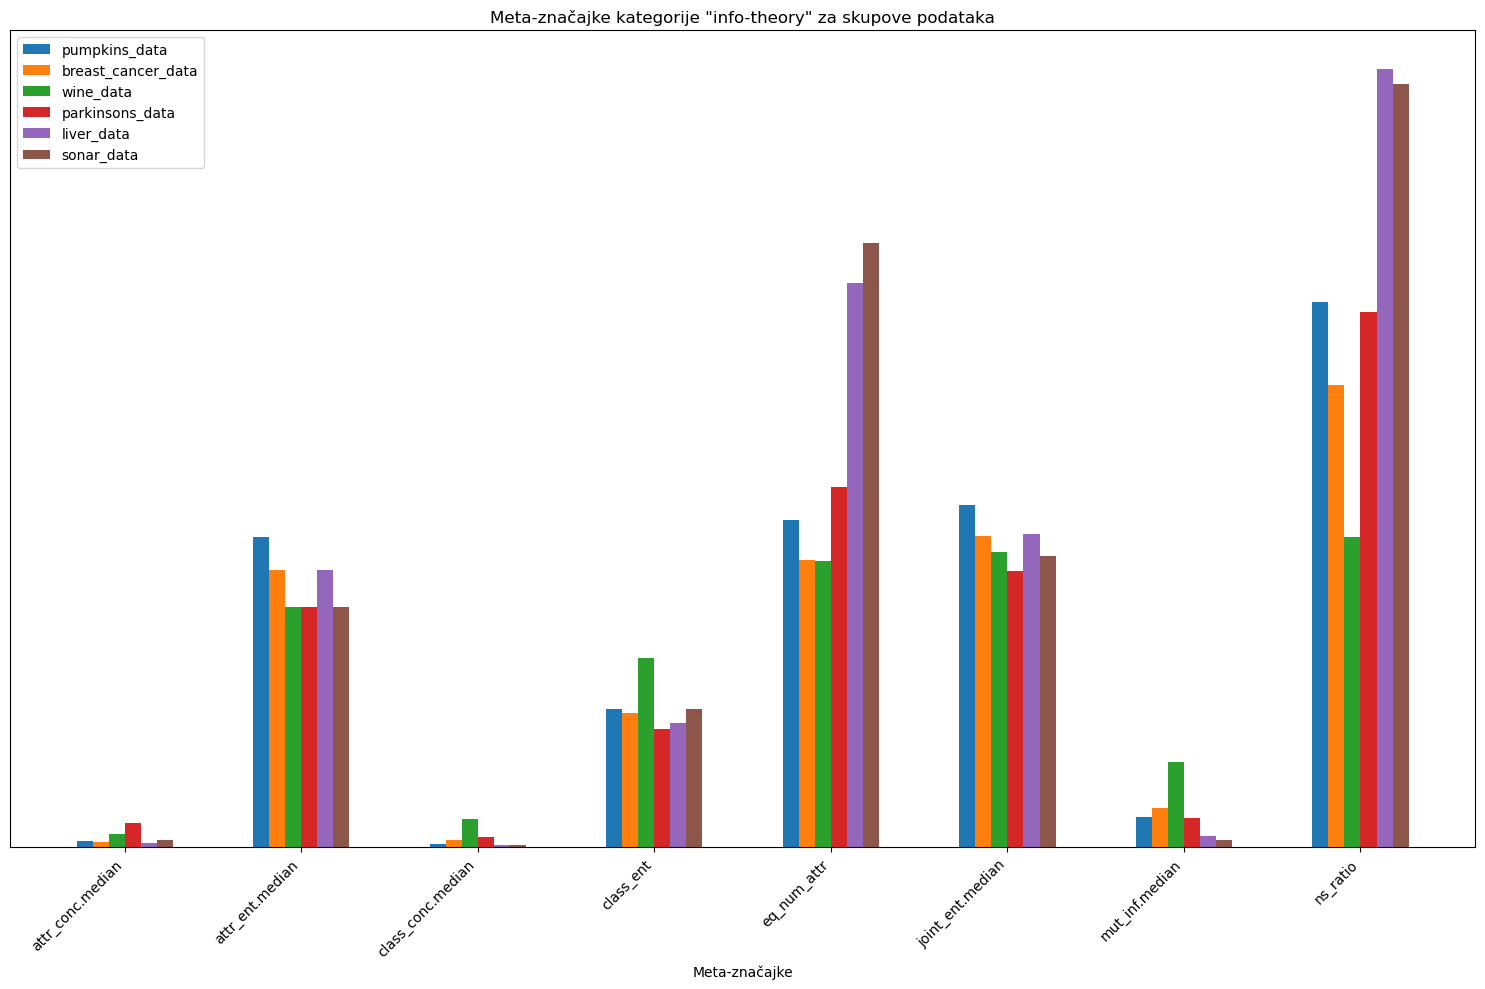

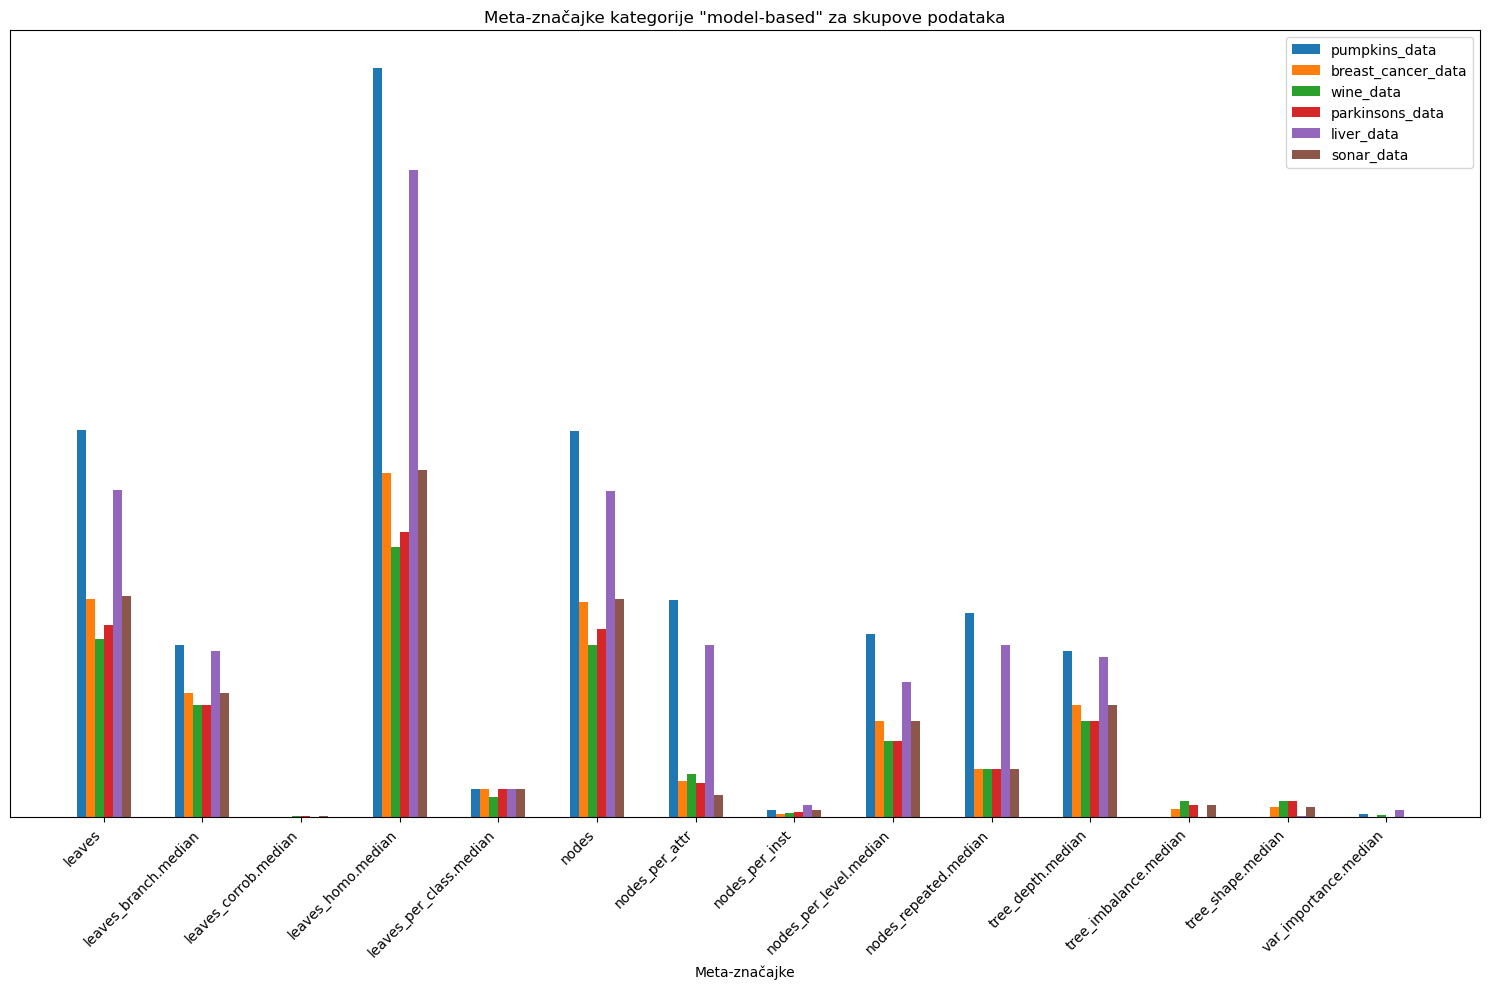

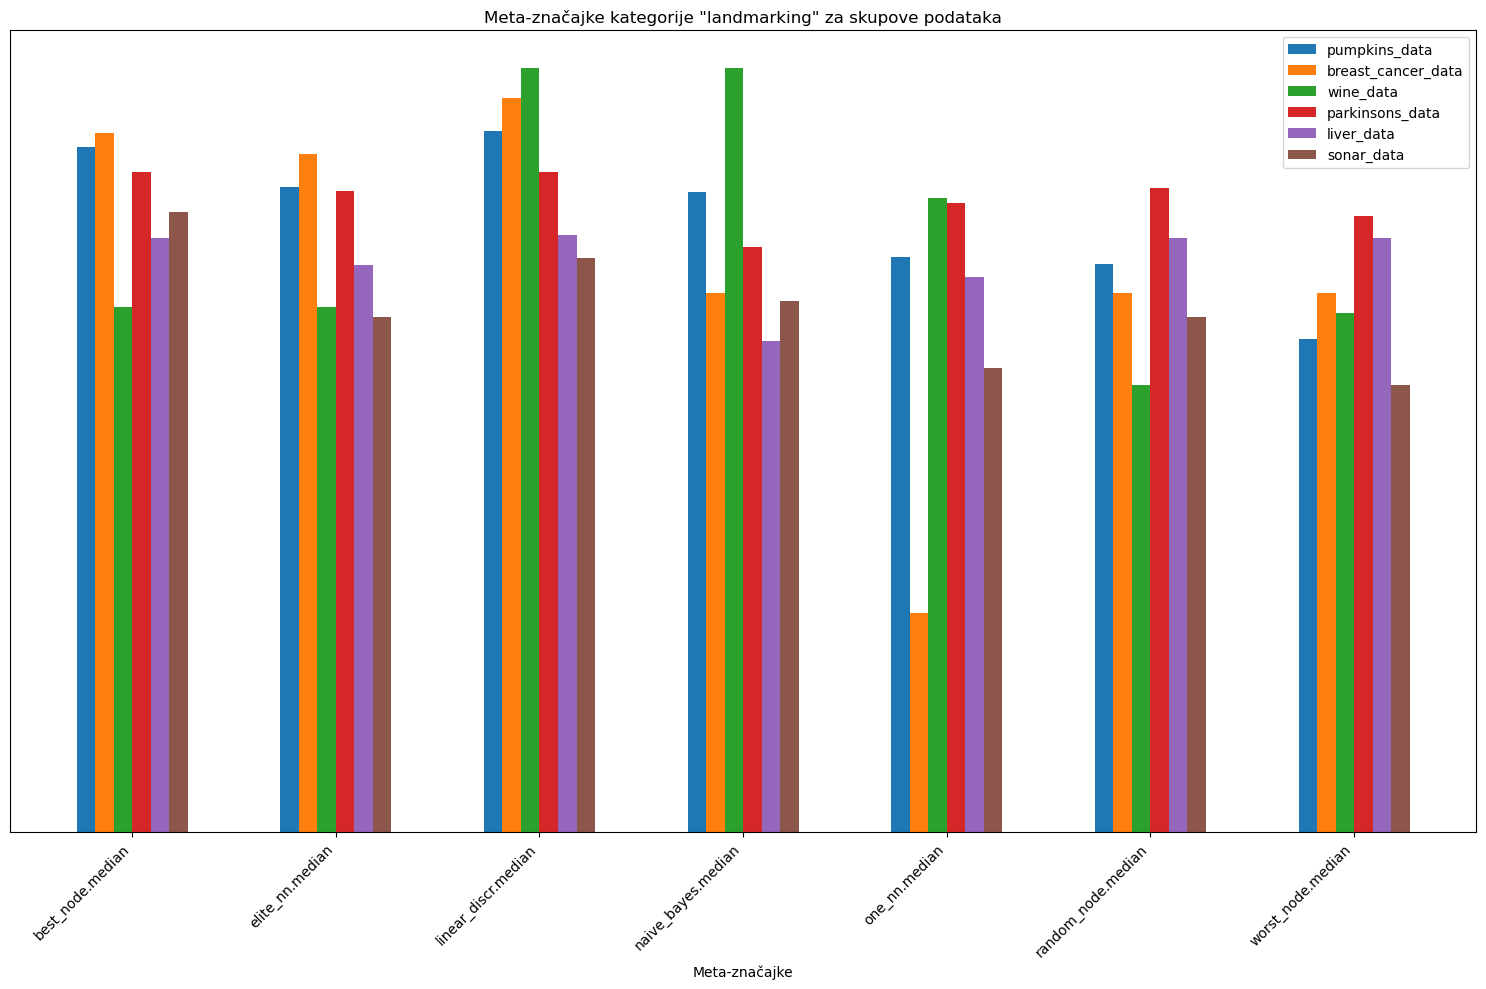

In [16]:
def log_transform(df):
    return np.log1p(df)

for group_idx, category in enumerate(mfe_categories):

    current_group_metafeatures = [dataset_metafeatures[group_idx] for dataset_metafeatures in meta_knowledge_mfe]
    graph_data = pd.DataFrame(current_group_metafeatures)

    if 'bestAlg' in graph_data.columns:
        graph_data.drop('bestAlg', axis=1, inplace=True)
    graph_data = graph_data.transpose()
    graph_data.columns = target_variable_names.keys()

    graph_data_transformed = graph_data.apply(log_transform)

    bar_width = 0.1
    spacing = 0.1
    index = [i + i*spacing for i in range(len(graph_data_transformed.index))]

    fig, ax = plt.subplots(figsize=(15, 10))

    for i, dataset in enumerate(graph_data_transformed.columns):
        ax.bar([x + i*bar_width for x in index], graph_data_transformed[dataset], width=bar_width, label=dataset)

    ax.set_xlabel('Meta-značajke')
    ax.set_title(f'Meta-značajke kategorije "{category}" za skupove podataka')
    ax.set_xticks([x + (bar_width*(len(graph_data_transformed.columns)-1)/2) for x in index])
    ax.set_xticklabels(graph_data_transformed.index, rotation=45, ha='right')
    ax.legend()

    ax.set_yticks([])
    ax.set_ylabel('')

    plt.tight_layout()
    plt.show()

#### Učenje meta-učenika te izračunavanje preporučenih algoritama

In [17]:
#New code
scaler = StandardScaler()
algorithm_names = [meta[-1]["bestAlg"] for meta in meta_knowledge_mfe]
label_encoder = LabelEncoder()
encoded_algo_names = label_encoder.fit_transform(algorithm_names)

classifiers = {}

for i, category in enumerate(mfe_categories):

    X_meta = [meta[i] for meta in meta_feature_model_dataset]

    y_meta = encoded_algo_names
    meta_df = pd.DataFrame(X_meta)

    max_length = max(len(sublist) for sublist in X_meta)
    padded_list = [sublist + [0] * (max_length - len(sublist)) for sublist in X_meta]
    X_meta_np = np.array(padded_list)

    X_meta_scaled = scaler.fit_transform(np.array(X_meta_np))

    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    rf.fit(X_meta_scaled ,y_meta)
    
    classifiers[category] = rf

    classifiers